## Reddit data-set for sarcasm detection (pt 1)

The Sarcasm on Reddit dataset provides comments posted on Reddit labeled as sarcastic (1) or not sarcastic (0).
The task of the project is, given only the parent comment and the Reddit category (subreddit), to predict the probability of a parent comment to receive a sarcastic comment.

Download the dataset and unzip it.

In [1]:
#import kaggle
#kaggle.api.authenticate()
#kaggle.api.dataset_download_files('danofer/sarcasm', unzip=True)

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from scipy.sparse import hstack
import nltk
nltk.download('vader_lexicon') # VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment intensity tool added to NLTK in 2014
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# Importing the Keras libraries and packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as lg
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [4]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

In [5]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
from textblob import TextBlob

## Data-set analysis

We import the data and analyze it.

As the creator of the dataset states the Reddit dataset contains 1.3 million Sarcastic comments from the Internet commentary website Reddit and it was generated by scraping comments from Reddit containing the \s (sarcasm) tag. This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content.

In [6]:
red = pd.read_csv('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/Dataset/train-balanced-sarcasm.csv')
red.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [7]:
print(red.shape[0])  # gives number of row count
print(red.shape[1])  # gives number of col count

1010826
10


In [8]:
print(red['parent_comment'][5])
print(red['comment'][5])
print(red['label'][5])

do you find ariana grande sexy ?
I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)
0


The analysis will begin by focusing on a small sample of the dataset since as it is possible to observe from the previous command the dataset (not yet pre-processed) contains 1010826 rows, 962295 unique values (as for what concerns the comments' column) and 984286 unique values (for the parent comment section). The difference between the total number of rows of the data frame, that of the comments and the ones of the parent comments implies that there are some nan values. As a matter of fact:

In [9]:
red.isnull().sum() # There are 53 nan values for the comments' column

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [10]:
red = red[red['comment'].notna()]
red.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [11]:
red_sample = red.sample(frac = 0.1) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1])  # gives number of col count

101077
10


In [12]:
## Let's check the number of unique values in the label columns: this operation should confirm that we only have two labels:
# 0 = non sarcastic comment
# 1 = sarcastic comment
red_sample['label'].nunique()

2

Based on the information given by its owner the dataset should be balanced, this however an analysis of the distribution of the labels will follow, in order to check whether we need to adjust the class distribution of our dataset using adapting techniques such as oversampling or undersampling.

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

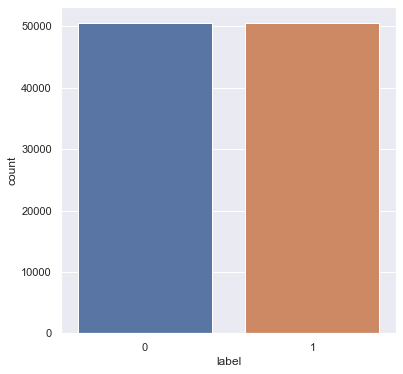

In [13]:
sns.set(rc={'figure.figsize':(6,6)})
sns.countplot(red_sample['label']) # The dataset, or in this case the sample, is confirmed to be balanced

Let's consider one comment to undrstand tokenization, lemmatization, stopwords removal and POS tagging.

In [14]:
example = red['parent_comment'][0]

In [15]:
example

"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."

In [16]:
example_comment = red['comment'][0]

In [17]:
example_comment

'NC and NH.'

In [18]:
example_label = red['label'][0]
example_label

0

In [19]:
## Example of SENTENCE tokenization
from nltk.tokenize import sent_tokenize
tokenized_sentence_example = sent_tokenize(example)
print(tokenized_sentence_example)

['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [20]:
## Example of WORD tokenization
from nltk.tokenize import word_tokenize
tokenized_word_example = word_tokenize(example)
print(tokenized_word_example)

['Yeah', ',', 'I', 'get', 'that', 'argument', '.', 'At', 'this', 'point', ',', 'I', "'d", 'prefer', 'is', 'she', 'lived', 'in', 'NC', 'as', 'well', '.']


In [21]:
## Word frequency distribution
from nltk.probability import FreqDist
freqDistrib = FreqDist(tokenized_word_example)
print(freqDistrib)

<FreqDist with 19 samples and 22 outcomes>


In [22]:
freqDistrib.most_common(3)

[(',', 2), ('I', 2), ('.', 2)]

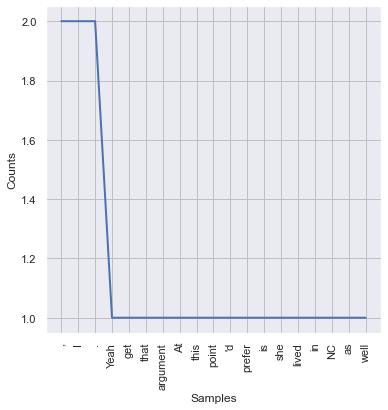

In [23]:
freqDistrib.plot(30,cumulative=False)
plt.show()

In [24]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{'y', 'he', 'your', 'himself', 'yourselves', 'again', 'by', 'own', 'themselves', "don't", 'be', 'or', 'to', 'no', 'can', 'as', 'isn', 'hadn', 'once', 'between', 'with', 'why', 'through', 'such', 'ma', 'that', 'hers', 'them', 'd', "didn't", 'most', 'so', 'not', 'about', 'at', 'won', 're', 'herself', 'on', 'the', 'an', 'will', 'm', 'this', 'its', 'other', 'too', 'i', 'hasn', 'off', 'she', "she's", 'does', 'ain', 'me', 'here', 'myself', 'against', "you've", 'you', 'o', 'which', 'his', 'having', 'yours', 'more', "you'd", 'doesn', 'further', "needn't", 'below', 'yourself', "should've", 'out', 'just', 'how', "shan't", 'what', 'wasn', 'up', "couldn't", 'ours', 's', 'is', 'has', "shouldn't", 'had', 'for', 'there', 'it', 'now', 'few', 'nor', "haven't", 'mightn', "hadn't", 'down', 'weren', 'ourselves', 'doing', 'after', 'we', "you'll", 'above', 'was', 'some', 'over', 'needn', 'very', 'don', 'my', 'who', 'whom', 'only', 'while', 'before', 'into', 'll', 'wouldn', 'of', "wasn't", 'been', 'have', 'a

In [25]:
filteredSentence = []
for w in tokenized_sentence_example:
    if w not in stop_words:
        filteredSentence.append(w)
print("Tokenized Sentence:",tokenized_sentence_example)
print("Filterd Sentence:",filteredSentence)

Tokenized Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Filterd Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [26]:
## Stemming
from nltk.stem import PorterStemmer

stemmedWords=[]
for w in filteredSentence:
    stemmedWords.append(PorterStemmer().stem(w))

print("Filtered Sentence:",filteredSentence)
print("Stemmed Sentence:",stemmedWords)

Filtered Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Stemmed Sentence: ['yeah, i get that argument.', "at this point, i'd prefer is she lived in nc as well."]


In [27]:
## Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

word = "pretty"
print("Lemmatized Word:",WordNetLemmatizer().lemmatize(word))
print("Stemmed Word:",PorterStemmer().stem(word))

Lemmatized Word: pretty
Stemmed Word: pretti


In [28]:
## POS tagging
nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(tokenized_word_example)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('Yeah', 'UH'),
 (',', ','),
 ('I', 'PRP'),
 ('get', 'VBP'),
 ('that', 'DT'),
 ('argument', 'NN'),
 ('.', '.'),
 ('At', 'IN'),
 ('this', 'DT'),
 ('point', 'NN'),
 (',', ','),
 ('I', 'PRP'),
 ("'d", 'MD'),
 ('prefer', 'VB'),
 ('is', 'VBZ'),
 ('she', 'PRP'),
 ('lived', 'VBD'),
 ('in', 'IN'),
 ('NC', 'NNP'),
 ('as', 'RB'),
 ('well', 'RB'),
 ('.', '.')]

### Dependency parser

In [29]:
nlp = spacy.load("en_core_web_sm")

In [30]:
from spacy import displacy

In [31]:
s_example = nlp(example)

In [32]:
displacy.render(s_example, style='dep')

## Distribution of sarcastic and non sarcastic comments

In order to compute what is the probability that given only the subreddit and the parent comment, the parent comment is associated with a sarcastic comment it is necessary to drop all the other columns.

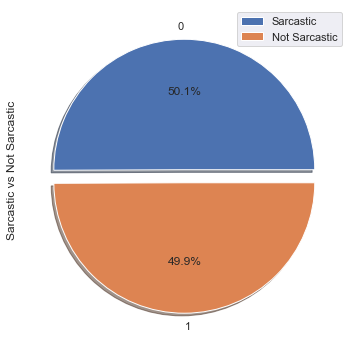

In [33]:
# Pie chart
red_sample["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Sarcastic vs Not Sarcastic")
plt.legend(["Sarcastic", "Not Sarcastic"])
plt.show()

### Exploratory Analysis

It might be interesting to perform some exploratory analysis on the dataset.

In [34]:
## Number of unique comment author
red_sample['author'].nunique()

74230

In [35]:
## Number of unique subreddit
red_sample['subreddit'].nunique()

5576

In [36]:
# Create a copy of the original dataset
red_copy = red_sample.copy()

Focusing on the column of the comments.

In [37]:
## Group and count the comments by author and label
red_sample.groupby(['author', 'label'],as_index=False).agg({'comment':'count'})

,author,label,comment
0,--------__--------,0,1
1,--------__--------,1,1
2,-----BroAway-----,0,1
3,-----BroAway-----,1,1
4,----branflakes----,1,1
...,...,...,...
85711,zzz---,1,1
85712,zzz802,0,1
85713,zzzhhh123,0,1
85714,zzzxxc1,1,1


In [38]:
## Return the number of sarcastic comment per each author
sarcasm_count_by_author = red_sample.groupby('author')['label'].agg([np.sum])
sarcasm_count_by_author

,sum
author,
--------__--------,1
-----BroAway-----,1
----branflakes----,1
---Earth---,1
--4-8-15-16-23-42,2
...,...
zzz---,1
zzz802,0
zzzhhh123,0


In [39]:
## Group and count the comments by author
comment_count_by_author = red_sample.groupby(['author'],as_index=False).agg({'comment':'count'})
comment_count_by_author

,author,comment
0,--------__--------,2
1,-----BroAway-----,2
2,----branflakes----,1
3,---Earth---,3
4,--4-8-15-16-23-42,2
...,...,...
74225,zzz---,1
74226,zzz802,1
74227,zzzhhh123,1
74228,zzzxxc1,1


In [40]:
comment_sum_up = pd.merge(sarcasm_count_by_author, comment_count_by_author, on='author')
comment_sum_up

,author,sum,comment
0,--------__--------,1,2
1,-----BroAway-----,1,2
2,----branflakes----,1,1
3,---Earth---,1,3
4,--4-8-15-16-23-42,2,2
...,...,...,...
74225,zzz---,1,1
74226,zzz802,0,1
74227,zzzhhh123,0,1
74228,zzzxxc1,1,1


In [41]:
comment_sum_up['percentage of sarcastic comments'] = comment_sum_up['sum']/comment_sum_up['comment']
comment_sum_up

,author,sum,comment,percentage of sarcastic comments
0,--------__--------,1,2,0.500000
1,-----BroAway-----,1,2,0.500000
2,----branflakes----,1,1,1.000000
3,---Earth---,1,3,0.333333
4,--4-8-15-16-23-42,2,2,1.000000
...,...,...,...,...
74225,zzz---,1,1,1.000000
74226,zzz802,0,1,0.000000
74227,zzzhhh123,0,1,0.000000
74228,zzzxxc1,1,1,1.000000


In [42]:
## Most sarcastic author:
print("The most sarastic author is: %15s" % (comment_count_by_author['author'].loc[comment_count_by_author['comment'].idxmax()]))

The most sarastic author is:     Biffingston


Some further analysis

In [43]:
## Group and count the comments by author and label
red_sample.groupby(['subreddit', 'label'],as_index=False).agg({'comment':'count'})

,subreddit,label,comment
0,100thieves,0,1
1,1022,0,1
2,10cloverfieldlane,1,2
3,1200isjerky,0,1
4,1200isplenty,0,2
...,...,...,...
7974,zombies,0,3
7975,zombies,1,2
7976,zootopia,0,5
7977,zweiteliga,1,1


In [44]:
## Return the number of sarcastic comment per each subreddit
sarcasm_count_by_subreddit = red_sample.groupby('subreddit')['label'].agg([np.sum])
sarcasm_count_by_subreddit

,sum
subreddit,
100thieves,0
1022,0
10cloverfieldlane,2
1200isjerky,0
1200isplenty,0
...,...
zenfone2,0
zombies,2
zootopia,0


In [45]:
## Group and count the comments by author
comment_count_by_subreddit = red_sample.groupby(['subreddit'],as_index=False).agg({'comment':'count'})
comment_count_by_subreddit

,subreddit,comment
0,100thieves,1
1,1022,1
2,10cloverfieldlane,2
3,1200isjerky,1
4,1200isplenty,2
...,...,...
5571,zenfone2,1
5572,zombies,5
5573,zootopia,5
5574,zweiteliga,1


In [46]:
subreddit_comment_sum_up = pd.merge(sarcasm_count_by_subreddit, comment_count_by_subreddit, on='subreddit')
subreddit_comment_sum_up

,subreddit,sum,comment
0,100thieves,0,1
1,1022,0,1
2,10cloverfieldlane,2,2
3,1200isjerky,0,1
4,1200isplenty,0,2
...,...,...,...
5571,zenfone2,0,1
5572,zombies,2,5
5573,zootopia,0,5
5574,zweiteliga,1,1


In [47]:
subreddit_comment_sum_up['percentage of sarcastic comments'] = subreddit_comment_sum_up['sum']/subreddit_comment_sum_up['comment']
subreddit_comment_sum_up

,subreddit,sum,comment,percentage of sarcastic comments
0,100thieves,0,1,0.0
1,1022,0,1,0.0
2,10cloverfieldlane,2,2,1.0
3,1200isjerky,0,1,0.0
4,1200isplenty,0,2,0.0
...,...,...,...,...
5571,zenfone2,0,1,0.0
5572,zombies,2,5,0.4
5573,zootopia,0,5,0.0
5574,zweiteliga,1,1,1.0


In [48]:
## Most sarcastic subreddit
print("The most sarastic subreddit is: %15s" % (comment_count_by_subreddit['subreddit'].loc[comment_count_by_subreddit['comment'].idxmax()]))

The most sarastic subreddit is:       AskReddit


In [49]:
subreddits = red_sample['subreddit'].value_counts()

In [50]:
pd.DataFrame(subreddits)

,subreddit
AskReddit,6525
politics,3981
worldnews,2675
leagueoflegends,2004
funny,1916
...,...
DD_CircleJerk,1
PokemonGoMPLS,1
CivCraftAytos,1
rockford,1


In [51]:
top_ten = subreddits.head(10)
top_ten = pd.DataFrame(top_ten)

In [52]:
top_ten['sub'] = top_ten.index

In [53]:
top_ten

,subreddit,sub
AskReddit,6525,AskReddit
politics,3981,politics
worldnews,2675,worldnews
leagueoflegends,2004,leagueoflegends
funny,1916,funny
pcmasterrace,1879,pcmasterrace
news,1721,news
pics,1657,pics
nba,1402,nba
nfl,1385,nfl


In [54]:
top_ten = top_ten.reset_index(drop=True)
top_ten

,subreddit,sub
0,6525,AskReddit
1,3981,politics
2,2675,worldnews
3,2004,leagueoflegends
4,1916,funny
5,1879,pcmasterrace
6,1721,news
7,1657,pics
8,1402,nba
9,1385,nfl


In [55]:
df = red_sample[red_sample.set_index(['subreddit']).index.isin(top_ten.set_index(['sub']).index)]
df = pd.DataFrame(df)

In [56]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
444572,1,I forgot the,Murdoch44,worldnews,0,0,0,2016-04,2016-04-14 04:35:51,"Coal decays, you probably wouldn't want to do ..."
380800,0,Yep imo Sanders probably benefited from Iowa a...,DoctorDrakin,politics,4,4,0,2016-02,2016-02-28 05:48:44,Caucuses are good for underdog candidates...
337783,0,Under your regular shorts...,Obviouslyapro,AskReddit,1,1,0,2016-08,2016-08-05 17:06:10,Like compression shorts under your regular sho...
163626,1,That's what you call unintended consequences.,Bleeds_Green,politics,0,-1,-1,2016-11,2016-11-03 14:41:34,Voting restrictions could hurt Clinton in N.C.
409757,1,It's all Sweden up there!,BigBlueBurd,worldnews,0,0,0,2016-02,2016-02-26 15:20:15,Uh... Oslo is the capital of Norway. :P


In [57]:
#df.loc[df.label == '1', df.subreddit == 'AskReddit'].count()
print(df[(df['label']==1) & (df['subreddit']=='AskReddit')].count())
print(df[(df['label']==0) & (df['subreddit']=='AskReddit')].count())

label             2576
comment           2576
author            2576
subreddit         2576
score             2576
ups               2576
downs             2576
date              2576
created_utc       2576
parent_comment    2576
dtype: int64
label             3949
comment           3949
author            3949
subreddit         3949
score             3949
ups               3949
downs             3949
date              3949
created_utc       3949
parent_comment    3949
dtype: int64


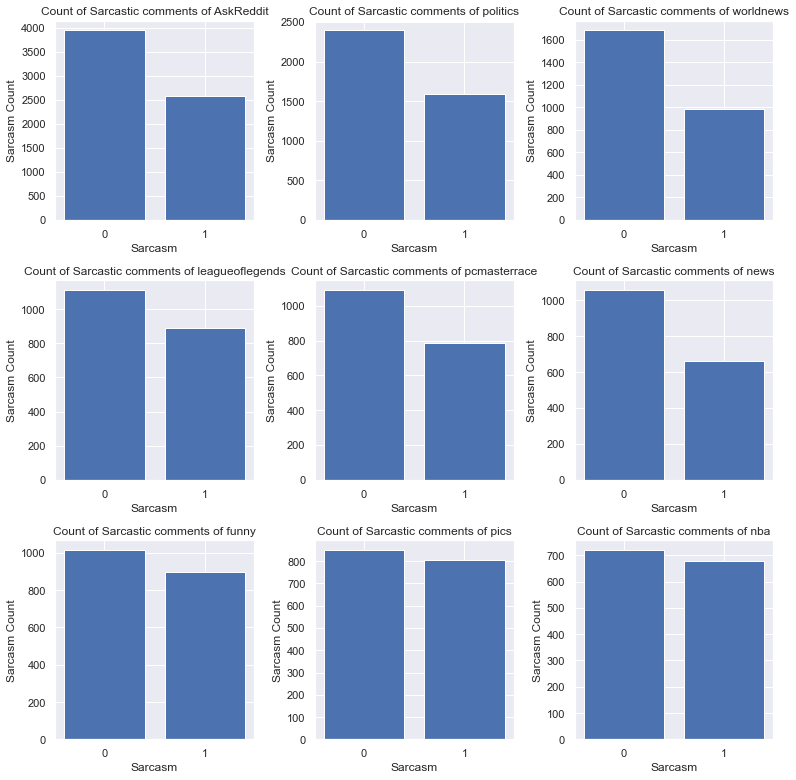

In [58]:
def plot_sub_sentiment(sub):
    dataFrame=df[df['subreddit']==sub]
    count=dataFrame['label'].value_counts()
    Index = [1,2]
    plt.bar(Index,count)
    plt.xticks(Index,['0','1'])
    plt.ylabel('Sarcasm Count')
    plt.xlabel('Sarcasm')
    plt.title('Count of Sarcastic comments of '+sub)
    plt.tight_layout()

plt.figure(1,figsize=(11, 11))
plt.subplot(331)
plot_sub_sentiment('AskReddit')
plt.subplot(332)
plot_sub_sentiment('politics')
plt.subplot(333)
plot_sub_sentiment('worldnews')
plt.subplot(334)
plot_sub_sentiment('leagueoflegends')
plt.subplot(335)
plot_sub_sentiment('pcmasterrace')
plt.subplot(337)
plot_sub_sentiment('funny')
plt.subplot(336)
plot_sub_sentiment('news')
plt.subplot(338)
plot_sub_sentiment('pics')
plt.subplot(339)
plot_sub_sentiment('nba')

#plt.savefig('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/images/sarcasm_count_per_subreddit.pdf')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "nfl"')]

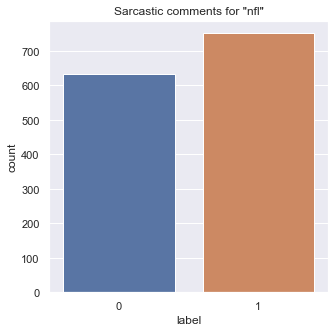

In [59]:
df_leagueoflegends = red_sample[red_sample['subreddit']==top_ten['sub'][9]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_leagueoflegends['label']).set(title = 'Sarcastic comments for "nfl"')

Let's print out the highest and the lowest scores first and then the corresponding comment and parent comment.

In [60]:
print("The minimum score assigned to a comment is %d, while the highest one is %d" % (red_sample['score'].min(), red_sample['score'].max()))

The minimum score assigned to a comment is -164, while the highest one is 5629


In [61]:
print('The Parent Comment of the comment with the highest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmax()])
print('\n The Comment with the highest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmax()])
if red_sample['label'].loc[red_sample['score'].idxmax()]==1:
    print('\n sarcastic')
else:
    print('\n not sarcastic')

The Parent Comment of the comment with the highest score is:
 The Worst "Got Talent" Judges Go on a Power Trip

 The Comment with the highest score is:
 He didn't drink the compliance

 not sarcastic


In [62]:
red_sample.loc[red_sample['score'].idxmax()]

label                                                            0
comment                             He didn't drink the compliance
author                                                       Muids
subreddit                                                   videos
score                                                         5629
ups                                                             -1
downs                                                           -1
date                                                       2016-12
created_utc                                    2016-12-20 19:25:52
parent_comment    The Worst "Got Talent" Judges Go on a Power Trip
Name: 53985, dtype: object

In [63]:
## Lowest score comment and its parent comment
print('The Parent Comment of the comment with the lowest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmin()])
print('\n The Comment with the lowest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmin()])
if red_sample['label'].loc[red_sample['score'].idxmin()]==1:
    print('\n sarcastic')
else:
    print('\n non sarcastic')

The Parent Comment of the comment with the lowest score is:
 Isn't the article describing a KKK rally.

 The Comment with the lowest score is:
 Everyone who doesn't like Hillary is a racist!

 sarcastic


In [64]:
red_sample.loc[red_sample['score'].idxmin()]

label                                                          1
comment           Everyone who doesn't like Hillary is a racist!
author                                                    probo1
subreddit                                               politics
score                                                       -164
ups                                                           -1
downs                                                         -1
date                                                     2016-10
created_utc                                  2016-10-29 21:33:39
parent_comment         Isn't the article describing a KKK rally.
Name: 46159, dtype: object

Analysis on the scores

In [65]:
# Mean and STD of Score Rating
mean = red_sample['score'].mean()
std = red_sample['score'].std()
print(mean, std)

7.088002216132256 54.958506308035446


## Text analysis

In [66]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [67]:
red_copy.drop(['author', 'score', 'date', 'created_utc'], axis=1, inplace=True) # rimangono ups and downs
red_copy.head(10)

,label,comment,subreddit,ups,downs,parent_comment
444572,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ..."
900110,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...
380800,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...
173947,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...
337783,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...
537214,0,This kills the prepromotes,fireemblem,9,0,This gave me horrible flashbacks to Ephraim225...
1003,0,May mays,Fireyourselfforkarma,-1,-1,Hey guys memes
756579,0,I bet that kid's face was delicious.,sad,-1,0,Baby's face eaten in ferret attack in Darby Bo...
155279,0,Especially when they fit perfectly with barely...,gamecollecting,2,0,CRT tvs parked in entertainment centers make m...
163626,1,That's what you call unintended consequences.,politics,-1,-1,Voting restrictions could hurt Clinton in N.C.


In [68]:
# Find the number of characters for each string in the red_sample dataset
red_copy['char'] = red_copy['parent_comment'].str.len()
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char
444572,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72
900110,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115
380800,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44
173947,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65
337783,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158


In [69]:
def plotDistr(var):
    plt.hist(red_copy[var][red_copy['label']==0], density=True, label='Not Sarcastic')
    plt.hist(red_copy[var][red_copy['label']==1], density=True, label='Sarcastic')
    plt.legend()
    plt.show()

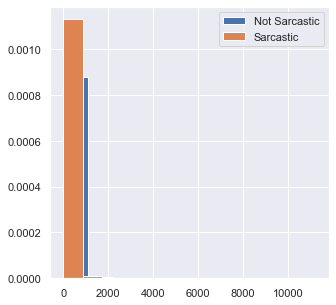

In [70]:
plotDistr('char')

In [71]:
# Number of punctuation symbols
red_copy['punct'] = red_copy['parent_comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct
444572,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2
900110,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4
380800,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3
173947,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3
337783,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2


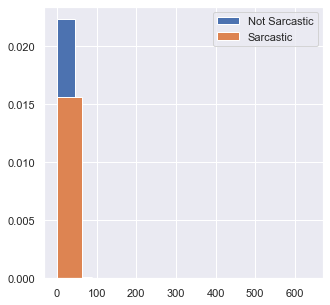

In [72]:
plotDistr('punct')

In [73]:
# Find the number of tokens for each string in the red_sample dataset
red_copy['tokens'] = red_copy['parent_comment'].str.split().str.len()
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens
444572,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14
900110,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21
380800,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6
173947,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11
337783,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27


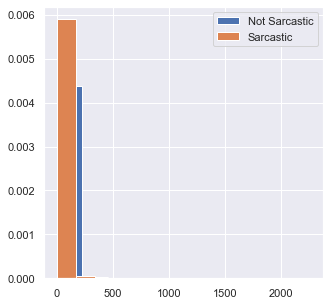

In [74]:
plotDistr('tokens')

In [75]:
# Cleaning the text of the parents' comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [76]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean"] = red_copy["parent_comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [77]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean_comment"] = red_copy["comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [78]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the parent comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the parent comments is: 3.0 minutes and 30.8 seconds


In [79]:
red_copy.reset_index(inplace=True)
red_copy.drop(['index'], axis=1, inplace=True)
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,forgot
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,one understand happen
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,switch exploud
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,regular short


In [80]:
boh = red_copy[['clean','clean_comment']]

In [81]:
boh["keywords_parent"] = boh["clean"].str.split("[^\w+]").map(set)

boh["keywords_children"] = boh["clean_comment"].str.split("[^\w+]").map(set)
boh

C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,clean,clean_comment,keywords_parent,keywords_children
0,coal decay probabl would want long term thing,forgot,"{thing, term, decay, coal, want, would, probab...",{forgot}
1,girl alway tri make dude look like idiot succe...,one understand happen,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}"
2,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef..."
3,say frantic tri fix batteri life issu,switch exploud,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}"
4,like compress short regular short compress sho...,regular short,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}"
...,...,...,...,...
101072,im happi complet angrychicken build spent run ...,drop difficulti,"{season, wonder, give, hope, far, renew, spent...","{difficulti, drop}"
101073,without govern would abus children serious abs...,kid want physic disciplin act,"{pun, absolut, govern, intend, serious, would,...","{physic, kid, act, want, disciplin}"
101074,yellow,teaminstinct,{yellow},{teaminstinct}
101075,obama invit refuge live palac,,"{refuge, live, palac, invit, obama}",{}


In [82]:
boh['common_words'] = [set(x[0].split()) & set(x[1].split()) for x in boh.values]
boh['overlap_count'] = boh['common_words'].str.len()
boh

C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,clean,clean_comment,keywords_parent,keywords_children,common_words,overlap_count
0,coal decay probabl would want long term thing,forgot,"{thing, term, decay, coal, want, would, probab...",{forgot},{},0
1,girl alway tri make dude look like idiot succe...,one understand happen,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}",{},0
2,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef...",{},0
3,say frantic tri fix batteri life issu,switch exploud,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}",{},0
4,like compress short regular short compress sho...,regular short,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}","{regular, short}",2
...,...,...,...,...,...,...
101072,im happi complet angrychicken build spent run ...,drop difficulti,"{season, wonder, give, hope, far, renew, spent...","{difficulti, drop}",{},0
101073,without govern would abus children serious abs...,kid want physic disciplin act,"{pun, absolut, govern, intend, serious, would,...","{physic, kid, act, want, disciplin}",{},0
101074,yellow,teaminstinct,{yellow},{teaminstinct},{},0
101075,obama invit refuge live palac,,"{refuge, live, palac, invit, obama}",{},{},0


In [83]:
boh

,clean,clean_comment,keywords_parent,keywords_children,common_words,overlap_count
0,coal decay probabl would want long term thing,forgot,"{thing, term, decay, coal, want, would, probab...",{forgot},{},0
1,girl alway tri make dude look like idiot succe...,one understand happen,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}",{},0
2,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef...",{},0
3,say frantic tri fix batteri life issu,switch exploud,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}",{},0
4,like compress short regular short compress sho...,regular short,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}","{regular, short}",2
...,...,...,...,...,...,...
101072,im happi complet angrychicken build spent run ...,drop difficulti,"{season, wonder, give, hope, far, renew, spent...","{difficulti, drop}",{},0
101073,without govern would abus children serious abs...,kid want physic disciplin act,"{pun, absolut, govern, intend, serious, would,...","{physic, kid, act, want, disciplin}",{},0
101074,yellow,teaminstinct,{yellow},{teaminstinct},{},0
101075,obama invit refuge live palac,,"{refuge, live, palac, invit, obama}",{},{},0


In [84]:
#boh['non_common_words'] = [set(x[1].split()) not in set(x[0].split()) for x in boh.values]
#boh['non_overlap_count'] = boh['non_common_words'].str.len()
#boh

### Sentiment Analysis

In [85]:
all_parent_comments = red_copy['parent_comment']
all_sent_values = []
all_sentiments = []

In [86]:
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

In [87]:
sample = red_copy['parent_comment'][1231]
print(sample)
print('Sentiment: ')
print(sentiment_value(sample))

Trump Picks Sen. Jeff Sessions For Attorney General
Sentiment: 
0.0


In [88]:
for i in range(0, red_copy.shape[0]):
    all_sent_values.append(sentiment_value(red_copy['parent_comment'][i]))

In [89]:
len(all_sent_values)

101077

In [90]:
all_parent_comments = pd.DataFrame(all_parent_comments)
all_parent_comments

,parent_comment
0,"Coal decays, you probably wouldn't want to do ..."
1,This girl is always trying to make this dude l...
2,Caucuses are good for underdog candidates...
3,$6 says they're frantically trying to fix the ...
4,Like compression shorts under your regular sho...
...,...
101072,im so happy i completed my angrychicken build....
101073,"But without government, who would abuse the ch..."
101074,Yellow!
101075,Obama invites U.S. refugees to live in his pos...


In [91]:
#Sentiment Analysis on the dataset
SENTIMENT_VALUE = []
SENTIMENT = []
for i in range(0, red_copy.shape[0]):
    sent = all_sent_values[i]
    if (sent<=1 and sent>=0.5):
        SENTIMENT.append('Highly Positive')
        SENTIMENT_VALUE.append(5)
    elif (sent<0.5 and sent>0):
        SENTIMENT.append('Positive')
        SENTIMENT_VALUE.append(4)
    elif (sent==0):
        SENTIMENT.append('Neutral')
        SENTIMENT_VALUE.append(3)
    elif (sent<0 and sent>=-0.5):
        SENTIMENT.append('Negative')
        SENTIMENT_VALUE.append(2)
    else:
        SENTIMENT.append('Highly Negative')
        SENTIMENT_VALUE.append(1)

In [92]:
all_parent_comments['sentiment_value'] = SENTIMENT_VALUE
all_parent_comments['sentiment'] = SENTIMENT

In [93]:
all_parent_comments

,parent_comment,sentiment_value,sentiment
0,"Coal decays, you probably wouldn't want to do ...",2,Negative
1,This girl is always trying to make this dude l...,4,Positive
2,Caucuses are good for underdog candidates...,4,Positive
3,$6 says they're frantically trying to fix the ...,2,Negative
4,Like compression shorts under your regular sho...,5,Highly Positive
...,...,...,...
101072,im so happy i completed my angrychicken build....,5,Highly Positive
101073,"But without government, who would abuse the ch...",1,Highly Negative
101074,Yellow!,3,Neutral
101075,Obama invites U.S. refugees to live in his pos...,3,Neutral


In [94]:
red_final1 = pd.merge(red_copy, all_parent_comments, left_index=True, right_index=True)

In [95]:
red_final = pd.merge(red_final1, boh, left_index=True, right_index=True)

In [96]:
red_final

,label,comment,subreddit,ups,downs,parent_comment_x,char,punct,tokens,clean_x,clean_comment_x,parent_comment_y,sentiment_value,sentiment,clean_y,clean_comment_y,keywords_parent,keywords_children,common_words,overlap_count
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,forgot,"Coal decays, you probably wouldn't want to do ...",2,Negative,coal decay probabl would want long term thing,forgot,"{thing, term, decay, coal, want, would, probab...",{forgot},{},0
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,one understand happen,This girl is always trying to make this dude l...,4,Positive,girl alway tri make dude look like idiot succe...,one understand happen,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}",{},0
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,Caucuses are good for underdog candidates...,4,Positive,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef...",{},0
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,switch exploud,$6 says they're frantically trying to fix the ...,2,Negative,say frantic tri fix batteri life issu,switch exploud,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}",{},0
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,regular short,Like compression shorts under your regular sho...,5,Highly Positive,like compress short regular short compress sho...,regular short,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}","{regular, short}",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,been doing it on t12.. should i drop the diffi...,diablo3,1,0,im so happy i completed my angrychicken build....,166,5,31,im happi complet angrychicken build spent run ...,drop difficulti,im so happy i completed my angrychicken build....,5,Highly Positive,im happi complet angrychicken build spent run ...,drop difficulti,"{season, wonder, give, hope, far, renew, spent...","{difficulti, drop}",{},0
101073,1,If those kids don't want to be physically disc...,Anarcho_Capitalism,21,0,"But without government, who would abuse the ch...",112,6,17,without govern would abus children serious abs...,kid want physic disciplin act,"But without government, who would abuse the ch...",1,Highly Negative,without govern would abus children serious abs...,kid want physic disciplin act,"{pun, absolut, govern, intend, serious, would,...","{physic, kid, act, want, disciplin}",{},0
101074,0,#TeamInstinct!,leagueoflegends,-1,-1,Yellow!,7,1,1,yellow,teaminstinct,Yellow!,3,Neutral,yellow,teaminstinct,{yellow},{teaminstinct},{},0
101075,1,If only.,The_Donald,-1,-1,Obama invites U.S. refugees to live in his pos...,67,3,10,obama invit refuge live palac,,Obama invites U.S. refugees to live in his pos...,3,Neutral,obama invit refuge live palac,,"{refuge, live, palac, invit, obama}",{},{},0


In [97]:
red_final.drop(['parent_comment_y','clean_y','clean_comment_y'], axis=1, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment_x,char,punct,tokens,clean_x,clean_comment_x,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,forgot,2,Negative,"{thing, term, decay, coal, want, would, probab...",{forgot},{},0
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,one understand happen,4,Positive,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}",{},0
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,4,Positive,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef...",{},0
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,switch exploud,2,Negative,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}",{},0
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,regular short,5,Highly Positive,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}","{regular, short}",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,been doing it on t12.. should i drop the diffi...,diablo3,1,0,im so happy i completed my angrychicken build....,166,5,31,im happi complet angrychicken build spent run ...,drop difficulti,5,Highly Positive,"{season, wonder, give, hope, far, renew, spent...","{difficulti, drop}",{},0
101073,1,If those kids don't want to be physically disc...,Anarcho_Capitalism,21,0,"But without government, who would abuse the ch...",112,6,17,without govern would abus children serious abs...,kid want physic disciplin act,1,Highly Negative,"{pun, absolut, govern, intend, serious, would,...","{physic, kid, act, want, disciplin}",{},0
101074,0,#TeamInstinct!,leagueoflegends,-1,-1,Yellow!,7,1,1,yellow,teaminstinct,3,Neutral,{yellow},{teaminstinct},{},0
101075,1,If only.,The_Donald,-1,-1,Obama invites U.S. refugees to live in his pos...,67,3,10,obama invit refuge live palac,,3,Neutral,"{refuge, live, palac, invit, obama}",{},{},0


In [98]:
red_final.rename(columns={'parent_comment_x':'parent_comment','clean_x':'clean','clean_comment_x':'clean_comment'}, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,forgot,2,Negative,"{thing, term, decay, coal, want, would, probab...",{forgot},{},0
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,one understand happen,4,Positive,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}",{},0
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,4,Positive,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef...",{},0
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,switch exploud,2,Negative,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}",{},0
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,regular short,5,Highly Positive,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}","{regular, short}",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,been doing it on t12.. should i drop the diffi...,diablo3,1,0,im so happy i completed my angrychicken build....,166,5,31,im happi complet angrychicken build spent run ...,drop difficulti,5,Highly Positive,"{season, wonder, give, hope, far, renew, spent...","{difficulti, drop}",{},0
101073,1,If those kids don't want to be physically disc...,Anarcho_Capitalism,21,0,"But without government, who would abuse the ch...",112,6,17,without govern would abus children serious abs...,kid want physic disciplin act,1,Highly Negative,"{pun, absolut, govern, intend, serious, would,...","{physic, kid, act, want, disciplin}",{},0
101074,0,#TeamInstinct!,leagueoflegends,-1,-1,Yellow!,7,1,1,yellow,teaminstinct,3,Neutral,{yellow},{teaminstinct},{},0
101075,1,If only.,The_Donald,-1,-1,Obama invites U.S. refugees to live in his pos...,67,3,10,obama invit refuge live palac,,3,Neutral,"{refuge, live, palac, invit, obama}",{},{},0


In [99]:
capital = []

In [100]:
for i in range(0, red_copy.shape[0]):
    capital.append(sum(map(str.isupper, red_copy['parent_comment'][i].split())))

In [101]:
red_final['cap'] = capital
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,forgot,2,Negative,"{thing, term, decay, coal, want, would, probab...",{forgot},{},0,0
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,one understand happen,4,Positive,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}",{},0,0
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,4,Positive,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef...",{},0,0
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,switch exploud,2,Negative,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}",{},0,0
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,regular short,5,Highly Positive,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}","{regular, short}",2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,been doing it on t12.. should i drop the diffi...,diablo3,1,0,im so happy i completed my angrychicken build....,166,5,31,im happi complet angrychicken build spent run ...,drop difficulti,5,Highly Positive,"{season, wonder, give, hope, far, renew, spent...","{difficulti, drop}",{},0,0
101073,1,If those kids don't want to be physically disc...,Anarcho_Capitalism,21,0,"But without government, who would abuse the ch...",112,6,17,without govern would abus children serious abs...,kid want physic disciplin act,1,Highly Negative,"{pun, absolut, govern, intend, serious, would,...","{physic, kid, act, want, disciplin}",{},0,0
101074,0,#TeamInstinct!,leagueoflegends,-1,-1,Yellow!,7,1,1,yellow,teaminstinct,3,Neutral,{yellow},{teaminstinct},{},0,0
101075,1,If only.,The_Donald,-1,-1,Obama invites U.S. refugees to live in his pos...,67,3,10,obama invit refuge live palac,,3,Neutral,"{refuge, live, palac, invit, obama}",{},{},0,1


In [102]:
red_final['uppercase'] = red_final['parent_comment'].str.findall(r'[A-Z]').str.len()
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,forgot,2,Negative,"{thing, term, decay, coal, want, would, probab...",{forgot},{},0,0,1
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,one understand happen,4,Positive,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}",{},0,0,1
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,4,Positive,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef...",{},0,0,1
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,switch exploud,2,Negative,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}",{},0,0,0
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,regular short,5,Highly Positive,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}","{regular, short}",2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,been doing it on t12.. should i drop the diffi...,diablo3,1,0,im so happy i completed my angrychicken build....,166,5,31,im happi complet angrychicken build spent run ...,drop difficulti,5,Highly Positive,"{season, wonder, give, hope, far, renew, spent...","{difficulti, drop}",{},0,0,2
101073,1,If those kids don't want to be physically disc...,Anarcho_Capitalism,21,0,"But without government, who would abuse the ch...",112,6,17,without govern would abus children serious abs...,kid want physic disciplin act,1,Highly Negative,"{pun, absolut, govern, intend, serious, would,...","{physic, kid, act, want, disciplin}",{},0,0,2
101074,0,#TeamInstinct!,leagueoflegends,-1,-1,Yellow!,7,1,1,yellow,teaminstinct,3,Neutral,{yellow},{teaminstinct},{},0,0,1
101075,1,If only.,The_Donald,-1,-1,Obama invites U.S. refugees to live in his pos...,67,3,10,obama invit refuge live palac,,3,Neutral,"{refuge, live, palac, invit, obama}",{},{},0,1,4


### Polarity analysis with textblob

In [103]:
red_final[['polarity', 'subjectivity']] = red_final['parent_comment'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [104]:
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,...,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,...,2,Negative,"{thing, term, decay, coal, want, would, probab...",{forgot},{},0,0,1,-0.050000,0.400000
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,...,4,Positive,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}",{},0,0,1,-0.050000,0.450000
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,...,4,Positive,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef...",{},0,0,1,0.700000,0.600000
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,...,2,Negative,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}",{},0,0,0,0.000000,0.000000
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,...,5,Highly Positive,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}","{regular, short}",2,0,2,0.069444,0.373932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,been doing it on t12.. should i drop the diffi...,diablo3,1,0,im so happy i completed my angrychicken build....,166,5,31,im happi complet angrychicken build spent run ...,...,5,Highly Positive,"{season, wonder, give, hope, far, renew, spent...","{difficulti, drop}",{},0,0,2,0.266667,0.700000
101073,1,If those kids don't want to be physically disc...,Anarcho_Capitalism,21,0,"But without government, who would abuse the ch...",112,6,17,without govern would abus children serious abs...,...,1,Highly Negative,"{pun, absolut, govern, intend, serious, would,...","{physic, kid, act, want, disciplin}",{},0,0,2,-0.666667,0.833333
101074,0,#TeamInstinct!,leagueoflegends,-1,-1,Yellow!,7,1,1,yellow,...,3,Neutral,{yellow},{teaminstinct},{},0,0,1,0.000000,0.000000
101075,1,If only.,The_Donald,-1,-1,Obama invites U.S. refugees to live in his pos...,67,3,10,obama invit refuge live palac,...,3,Neutral,"{refuge, live, palac, invit, obama}",{},{},0,1,4,0.136364,0.500000


In [105]:
#rated_dummies = pd.get_dummies(red_final.sentiment)

In [106]:
#red_final = pd.concat([red_final, rated_dummies], axis=1)
#red_final

In [107]:
red_final.drop(['sentiment_value'], axis=1, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,forgot,Negative,"{thing, term, decay, coal, want, would, probab...",{forgot},{},0,0,1,-0.050000,0.400000
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,one understand happen,Positive,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}",{},0,0,1,-0.050000,0.450000
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,Positive,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef...",{},0,0,1,0.700000,0.600000
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,switch exploud,Negative,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}",{},0,0,0,0.000000,0.000000
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,regular short,Highly Positive,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}","{regular, short}",2,0,2,0.069444,0.373932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,been doing it on t12.. should i drop the diffi...,diablo3,1,0,im so happy i completed my angrychicken build....,166,5,31,im happi complet angrychicken build spent run ...,drop difficulti,Highly Positive,"{season, wonder, give, hope, far, renew, spent...","{difficulti, drop}",{},0,0,2,0.266667,0.700000
101073,1,If those kids don't want to be physically disc...,Anarcho_Capitalism,21,0,"But without government, who would abuse the ch...",112,6,17,without govern would abus children serious abs...,kid want physic disciplin act,Highly Negative,"{pun, absolut, govern, intend, serious, would,...","{physic, kid, act, want, disciplin}",{},0,0,2,-0.666667,0.833333
101074,0,#TeamInstinct!,leagueoflegends,-1,-1,Yellow!,7,1,1,yellow,teaminstinct,Neutral,{yellow},{teaminstinct},{},0,0,1,0.000000,0.000000
101075,1,If only.,The_Donald,-1,-1,Obama invites U.S. refugees to live in his pos...,67,3,10,obama invit refuge live palac,,Neutral,"{refuge, live, palac, invit, obama}",{},{},0,1,4,0.136364,0.500000


## Wordcloud

WordCloud is a technique to show which words are the most frequent among the given text.
We start with only one comment:

Coal decays, you probably wouldn't want to do that for a long term thing


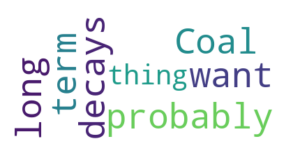

In [108]:
# Start with the first parent comment:
from wordcloud import WordCloud
parent = red_final.parent_comment[0]
print(parent)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(parent)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud on all the parent comments:

In [109]:
# Wordcloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_final['parent_comment'][red_final["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

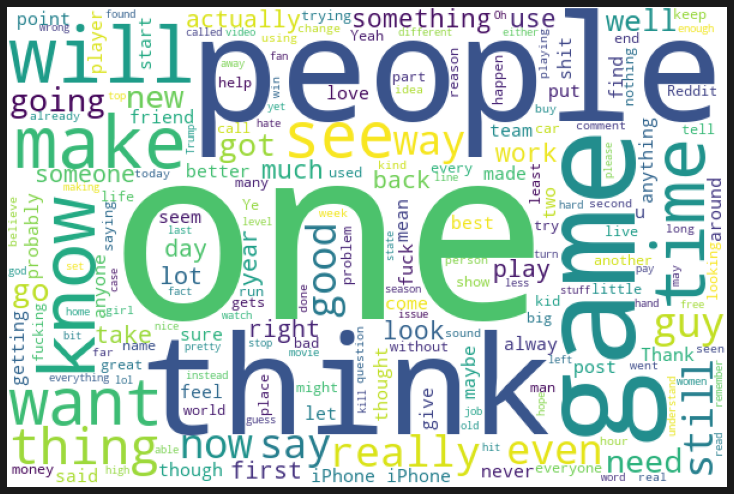

In [110]:
## Wordcloud for Non sarcastic comments
myWordCloud(0)

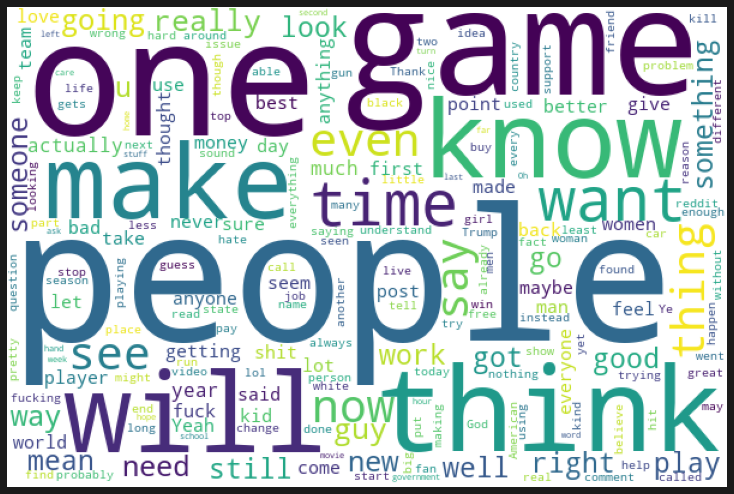

In [111]:
## Wordcloud for Sarcastic comments
myWordCloud(1)

Wordcloud with the cleaned version of the parent comments:

In [112]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_final['clean'][red_final["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

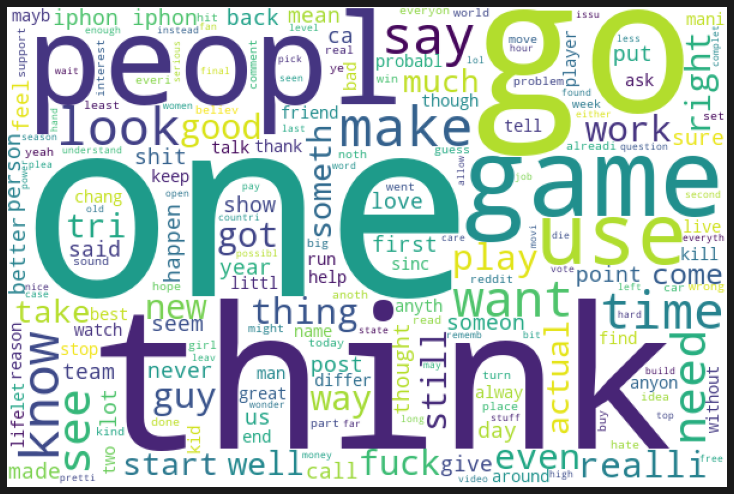

In [113]:
## Wordcloud for Non sarcastic comments
myWordCloudCleaned(0)

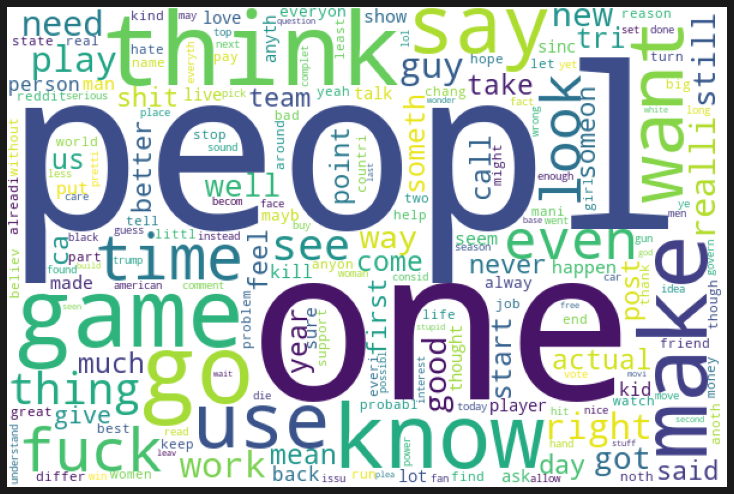

In [114]:
## Wordcloud for Sarcastic comments
myWordCloudCleaned(1)

## Split into train, test and validation set

In [115]:
red_final.rename(columns={'parent_comment':'parent'}, inplace=True)
red_final.head()

,label,comment,subreddit,ups,downs,parent,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,forgot,Negative,"{thing, term, decay, coal, want, would, probab...",{forgot},{},0,0,1,-0.050000,0.400000
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,one understand happen,Positive,"{dude, look, make, like, succeed, idiot, alway...","{understand, one, happen}",{},0,0,1,-0.050000,0.450000
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,Positive,"{good, underdog, candid, caucus}","{sander, nevada, yep, iowa, imo, system, benef...",{},0,0,1,0.700000,0.600000
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,switch exploud,Negative,"{frantic, fix, life, say, batteri, issu, tri}","{switch, exploud}",{},0,0,0,0.000000,0.000000
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,regular short,Highly Positive,"{look, odd, like, donger, becam, short, awar, ...","{regular, short}","{regular, short}",2,0,2,0.069444,0.373932


In [116]:
## Let's check the number of unique values in the subreddit columns
red_final['subreddit'].nunique()

5576

In [117]:
X = red_final.drop(['label'], axis = 1) 
y = red_final["label"]

In [118]:
#X = red_copy[['clean','subreddit']]
#y = red_copy['label']

In [119]:
X_train, red_test, y_train1, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [120]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train1, test_size=0.2, random_state=28)

In [121]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(64688, 19)
(16173, 19)
(20216, 19)
(64688,)
(16173,)
(20216,)


In [122]:
red_train.head()

,comment,subreddit,ups,downs,parent,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
72677,my chapters are coming in 3000-4000 words on t...,writing,1,0,Chapter lengths Is there any sort of unofficia...,215,6,38,chapter length sort unoffici recommend length ...,chapter come word first draft,Highly Positive,"{length, size, page, thought, like, recommend,...","{first, word, come, chapter, draft}","{chapter, word}",2,3,8,0.166667,0.516667
10531,What other duos are even there really?,Overwatch,-1,-1,I wouldn't say they are the best duo but yes t...,82,1,18,would say best duo yes lck cast fun listen,duo even realli,Highly Positive,"{fun, listen, say, would, yes, duo, cast, lck,...","{duo, even, realli}",{duo},1,2,4,0.650000,0.250000
97566,Just don't make stupid changes like the bison ...,tf2,-1,-1,What would it take for r/tf2 to enjoy an updat...,150,4,27,would take enjoy updat content would need subr...,make stupid chang like bison nerf,Positive,"{game, valv, ruin, complain, would, content, t...","{make, like, nerf, chang, stupid, bison}",{},0,0,2,0.000000,0.450000
74802,My girlfriend sneezes in her sleep regularly!,AskReddit,3,0,Why don't we sneeze in our sleep?,33,2,7,sneez sleep,girlfriend sneez sleep regular,Neutral,"{sleep, sneez}","{regular, sleep, girlfriend, sneez}","{sleep, sneez}",2,0,1,0.000000,0.000000
54306,Tear: Down,nottheonion,3,0,Gor: Bachev,11,0,2,gor bachev,tear,Neutral,"{bachev, gor}",{tear},{},0,0,2,0.000000,0.000000


In [123]:
red_val.head()

,comment,subreddit,ups,downs,parent,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
60690,And what is *that* supposed to mean?,opieandanthony,-1,-1,"I see your point and agree with you, but you'v...",139,4,27,see point agre got control other see pejor con...,suppos mean,Negative,"{thing, see, point, control, agre, other, got,...","{suppos, mean}",{},0,1,2,0.0,1.00
21264,Whataboutisms really make you look like you ha...,news,-1,-1,So what do you make of the fact that Trump cal...,244,10,43,make fact trump call march washignton obama su...,whatabout realli make look like moral high ground,Highly Positive,"{call, member, tantrum, arm, well, make, suppo...","{moral, look, make, whatabout, like, high, gro...",{make},1,0,7,0.0,0.00
28271,"So essentially, a Moto X Style with better pro...",droidturbo,3,0,Motorola Droid Turbo 2 Mobile review: Challeng...,71,1,12,motorola droid turbo mobil review challeng top...,essenti moto x style better process snapdragon vs,Positive,"{motorola, turbo, dxomark, droid, mobil, revie...","{x, style, better, essenti, vs, moto, snapdrag...",{},0,0,8,0.5,0.75
41858,Fair trade...,DarkSouls2,7,0,got red lion cape or helm?,26,1,6,got red lion cape helm,fair trade,Neutral,"{helm, red, lion, got, cape}","{fair, trade}",{},0,0,0,0.0,0.00
68294,So many surgeries incoming,starcraft,1,0,What i think of when someone says starcraft ba...,51,0,9,think someon say starcraft balanc,mani surgeri incom,Neutral,"{someon, balanc, starcraft, say, think}","{surgeri, mani, incom}",{},0,0,1,0.0,0.00


## Classification algorithms

### First alternative
In the first alternative we wll have separate Tf-Idf vectorizers for comments and for subreddits.

#### TF-IDF on cleaned parent comments

TF-IDF focusing on the parent comments from which we have removed the punctuation and on which we have performed stemmization. 

In [124]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [125]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [126]:
clean_train = parent_vectorizer.fit_transform(red_train['clean'])
clean_valid = parent_vectorizer.transform(red_val['clean'])
clean_test = parent_vectorizer.transform(red_test['clean'])

In [127]:
subred_train = subreddits_vectorizer.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer.transform(red_test['subreddit'])

In [128]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

In [129]:
def addFeature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [130]:
#features = np.append(vectorizer.get_feature_names(), ['char','cap','punt','uppercase'])

In [131]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier as xgboost
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#### Naive Bayes

In [132]:
naive_bayes = NB.fit(reddit_train, y_train)

In [133]:
naiveBayes_predict = naive_bayes.predict(reddit_test)

In [134]:
metrics.accuracy_score(y_test, naiveBayes_predict)

0.5677681044717056

Cross Validation:

In [135]:
NB_cv = cross_val_score(NB, reddit_train, y_train, n_jobs = -1)
NB_cv

array([0.56971711, 0.56824857, 0.57095378, 0.57826389, 0.57022494])

#### Logistic Regression

In [136]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [137]:
## Fit the model
logit_model1 = logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.5s finished


In [138]:
y_pred_logit1 = logit_model1.predict(reddit_test)

Accurcay 0.5708349821923229
Precision 0.5708212560386473
Recall 0.5825281009662788
F1 score 0.5766152644934609


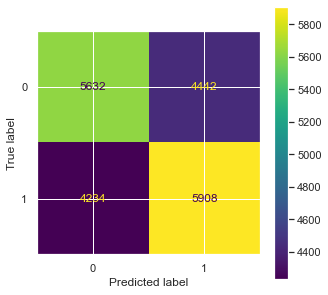

In [139]:
# print the model performance metrics
print("Accurcay",accuracy_score(y_test, y_pred_logit1))
print("Precision", precision_score(y_test, y_pred_logit1))
print("Recall",recall_score(y_test, y_pred_logit1))
print("F1 score",f1_score(y_test, y_pred_logit1))
plot_confusion_matrix(logit_model1, reddit_test, y_test)

#### KNN

In [140]:
knn_model1 = knn.fit(reddit_train, y_train) 

In [141]:
y_knn_pred1 = knn_model1.predict(reddit_test)
y_knn_pred1

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [142]:
print(knn_model1.score(reddit_test, y_test)) 

0.5259200633161852


#### Random Forest

In [143]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
random_forest_model1 = random_forest.fit(reddit_train, y_train)

In [144]:
randomForest_predict1 = random_forest_model1.predict(reddit_test)

In [145]:
metrics.accuracy_score(y_test, randomForest_predict1)

0.5257222002374357

Cross Validation:

In [146]:
rf_cv1 = cross_val_score(random_forest_model1, reddit_train, y_train, n_jobs = -1)
rf_cv1

array([0.51885917, 0.51638584, 0.52017313, 0.51905388, 0.52407823])

### Let's try with a new sentence
We decided to try with two questions from AskReddit

In [147]:
sent1 = {'subreddit': ['AskReddit'], 'parent': ['What is your dream job? (Serious)']}
proof = pd.DataFrame(sent1)

In [148]:
proof

,subreddit,parent
0,AskReddit,What is your dream job? (Serious)


In [149]:
X_sub1 = subreddits_vectorizer.transform(proof['subreddit'])
X_parent1 = parent_vectorizer.transform(proof['parent'])
X_sent1 = hstack([X_sub1, X_parent1])

In [150]:
X_sent1

<1x54570 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in COOrdinate format>

In [151]:
NB.predict_proba(X_sent1)

array([[0.61427773, 0.38572227]])

In [152]:
logit.predict_proba(X_sent1)

array([[0.6415642, 0.3584358]])

## Second Alternative

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [153]:
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,forgot
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,one understand happen
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,switch exploud
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,regular short


In [154]:
red_copy['text'] = red_copy.clean + " " + red_copy.subreddit
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,text
0,1,I forgot the,worldnews,0,0,"Coal decays, you probably wouldn't want to do ...",72,2,14,coal decay probabl would want long term thing,forgot,coal decay probabl would want long term thing ...
1,0,Am I the only one who doesn't understand what'...,cringepics,5,0,This girl is always trying to make this dude l...,115,4,21,girl alway tri make dude look like idiot succe...,one understand happen,girl alway tri make dude look like idiot succe...
2,0,Yep imo Sanders probably benefited from Iowa a...,politics,4,0,Caucuses are good for underdog candidates...,44,3,6,caucus good underdog candid,yep imo sander probabl benefit iowa nevada system,caucus good underdog candid politics
3,0,Switches explouding too?,wiiu,-1,-1,$6 says they're frantically trying to fix the ...,65,3,11,say frantic tri fix batteri life issu,switch exploud,say frantic tri fix batteri life issu wiiu
4,0,Under your regular shorts...,AskReddit,1,0,Like compression shorts under your regular sho...,158,2,27,like compress short regular short compress sho...,regular short,like compress short regular short compress sho...


In [155]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['text'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

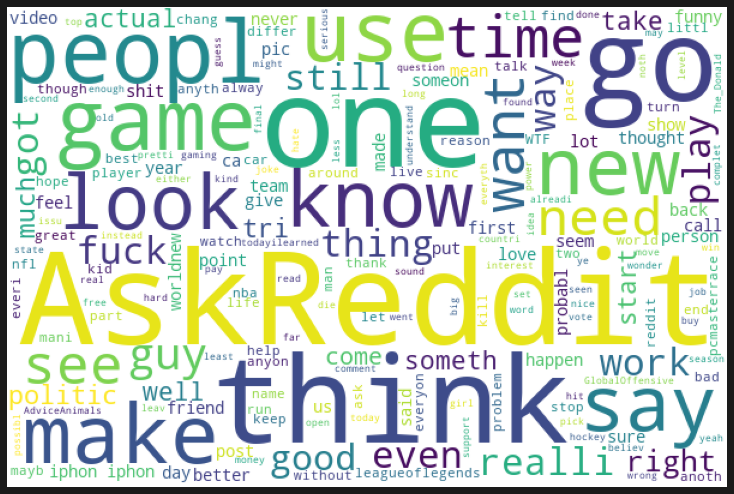

In [156]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

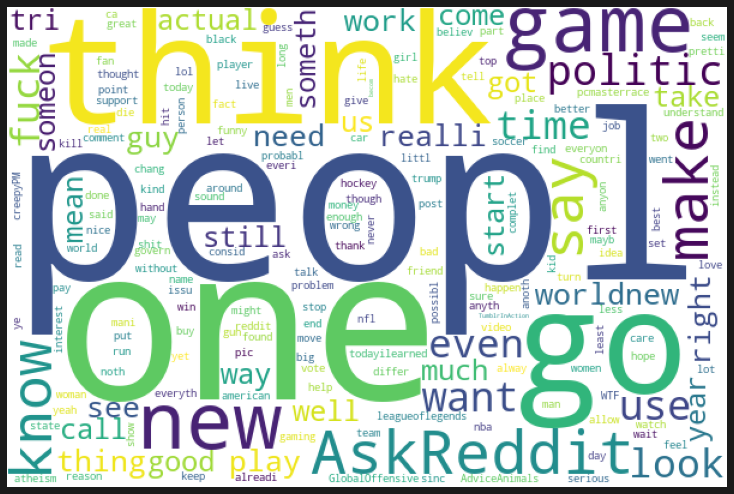

In [157]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [158]:
X2 = red_copy[['text']]
y2 = red_copy['label']

In [159]:
X2

,text
0,coal decay probabl would want long term thing ...
1,girl alway tri make dude look like idiot succe...
2,caucus good underdog candid politics
3,say frantic tri fix batteri life issu wiiu
4,like compress short regular short compress sho...
...,...
101072,im happi complet angrychicken build spent run ...
101073,without govern would abus children serious abs...
101074,yellow leagueoflegends
101075,obama invit refuge live palac The_Donald


In [160]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [161]:
clean_train2 = parent_vectorizer.fit_transform(X_train2['text'])
clean_test2 = parent_vectorizer.transform(red_test2['text'])

#### Naive Bayes

In [162]:
naive_bayes2 = NB.fit(clean_train2, y2_train)

In [163]:
naiveBayes_predict2 = naive_bayes2.predict(clean_test2)

In [164]:
metrics.accuracy_score(y2_test, naiveBayes_predict2)

0.5643055005935892

Cross Validation:

In [165]:
NB_cv2 = cross_val_score(NB, clean_train2, y2_train, n_jobs = -1)
NB_cv2

array([0.5672417 , 0.5732748 , 0.56919367, 0.56814247, 0.56993569])

#### Random forest

In [166]:
random_forest2 = RandomForestClassifier(max_depth=10, max_features=10)
random_forest2.fit(clean_train2, y2_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [167]:
randomForest_predict2 = random_forest2.predict(clean_test2)

In [168]:
metrics.accuracy_score(y2_test, randomForest_predict2)

0.5151365255243372

Cross Validation:

In [169]:
rf_cv2 = cross_val_score(random_forest2, clean_train2, y2_train, n_jobs = -1)
rf_cv2

array([0.51981698, 0.51719021, 0.51848875, 0.52547613, 0.51644818])

#### Logistic Regression

In [170]:
X2 = red_copy['text']
y2 = red_copy['label']

In [171]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [172]:
from sklearn.pipeline import Pipeline
tf_idf2 = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf2), 
                                 ('logit', logit)])

In [173]:
tfidf_logit_pipeline.fit(X_train2, y2_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.4s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [174]:
roc_auc_score(y2_test, tfidf_logit_pipeline.predict_proba(red_test2)[:,1])

0.5932069555727373

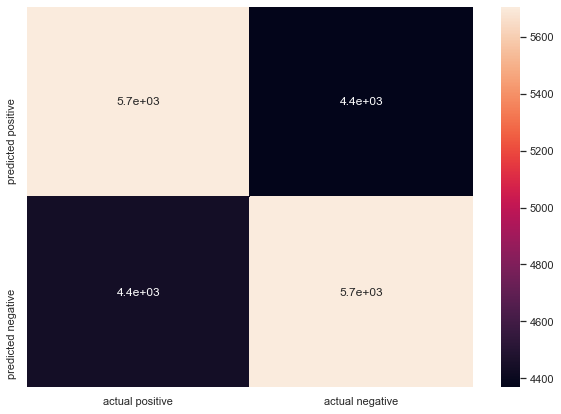

In [175]:
conf_mat2 = pd.DataFrame(confusion_matrix(y2_test, tfidf_logit_pipeline.predict(red_test2)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat2, annot=True)
plt.show()

### Let's make an example

In [176]:
sent2 = {'text': ['AskReddit: What is your dream job? (Serious)']}
proof2 = pd.DataFrame(sent2)

In [177]:
proof2

,text
0,AskReddit: What is your dream job? (Serious)


In [178]:
X_parent2 = parent_vectorizer.transform(proof2['text'])

In [179]:
naive_bayes2.predict_proba(X_parent2)

array([[0.52689921, 0.47310079]])

In [180]:
X_parent2 = tf_idf2.transform(proof2['text'])

In [181]:
logit.predict_proba(X_parent2)

array([[0.50601806, 0.49398194]])

#### GridSeachCV:

In [182]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

In [183]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [184]:
grid.fit(X_train2, y2_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    8.4s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   15.3s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [185]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2),use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train2, y2_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [186]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test2)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y2_test,predictions)),'\n')

Accuracy Score: 56.86% 



### Third Alternative

In [187]:
X_train3, red_test3, y_train_prov, y_test3 = train_test_split(X, y, test_size=0.20, random_state=28)

In [188]:
red_train3, red_val3, y_train3, y_val3 = train_test_split(X_train3, y_train_prov, test_size=0.2, random_state=28)

#### TF-IDF Vectorizers

In [189]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
sentiment_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [190]:
clean_train3 = parent_vectorizer.fit_transform(red_train3['clean'])
clean_valid3 = parent_vectorizer.transform(red_val3['clean'])
clean_test3 = parent_vectorizer.transform(red_test3['clean'])

In [191]:
subred_train3 = subreddits_vectorizer.fit_transform(red_train3['subreddit'])
subred_valid3 = subreddits_vectorizer.transform(red_val3['subreddit'])
subred_test3 = subreddits_vectorizer.transform(red_test3['subreddit'])

In [192]:
sent_train = sentiment_vectorizer.fit_transform(red_train3['sentiment'])
sent_valid = sentiment_vectorizer.transform(red_val3['sentiment'])
sent_test = sentiment_vectorizer.transform(red_test3['sentiment'])

reddit_train3 = hstack([subred_train3, sent_train])
reddit_valid3 = hstack([subred_valid3, sent_valid])
reddit_test3 = hstack([subred_test3, sent_test])

In [193]:
reddit_train1_3 = hstack([clean_train3, subred_train3])
reddit_valid1_3 = hstack([clean_valid3, subred_valid3])
reddit_test1_3 = hstack([clean_test3, subred_test3])

In [194]:
reddit_train3 = hstack([reddit_train1_3, sent_train])
reddit_valid3 = hstack([reddit_valid1_3, sent_valid])
reddit_test3 = hstack([reddit_test1_3, sent_test])

In [195]:
reddit_train3 = addFeature(reddit_train3, red_train3['overlap_count'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['overlap_count'])
reddit_test3 = addFeature(reddit_test3, red_test3['overlap_count'])

In [196]:
reddit_train3 = addFeature(reddit_train3, red_train3['char'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['char'])
reddit_test3 = addFeature(reddit_test3, red_test3['char'])

In [197]:
reddit_train3 = addFeature(reddit_train3, red_train3['cap'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['cap'])
reddit_test3 = addFeature(reddit_test3, red_test3['cap'])

In [198]:
reddit_train3 = addFeature(reddit_train3, red_train3['punct'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['punct'])
reddit_test3 = addFeature(reddit_test3, red_test3['punct'])

In [199]:
reddit_train3 = addFeature(reddit_train3, red_train3['uppercase'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['uppercase'])
reddit_test3 = addFeature(reddit_test3, red_test3['uppercase'])

In [200]:
reddit_train_copy = reddit_train3.copy()

In [201]:
reddit_train3 = addFeature(reddit_train3, red_train3['ups'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['ups'])
reddit_test3 = addFeature(reddit_test3, red_test3['ups'])

In [202]:
reddit_train3 = addFeature(reddit_train3, red_train3['downs'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['downs'])
reddit_test3 = addFeature(reddit_test3, red_test3['downs'])

In [203]:
reddit_train3 = addFeature(reddit_train3, red_train3['polarity'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['polarity'])
reddit_test3 = addFeature(reddit_test3, red_test3['polarity'])

#### XGBoost

In [204]:
xgboost = XGBClassifier()
xgboost_model3 = xgboost.fit(reddit_train3, y_train3)
y_pred_xgboost3 = xgboost_model3.predict(reddit_test3)

In [205]:
accuracy_xgboost3 = accuracy_score(y_test3, y_pred_xgboost3)
print("Accuracy: %.2f%%" % (accuracy_xgboost3 * 100.0))

Accuracy: 58.16%


Confusion matrix:
 [[6360 3714]
 [4744 5398]]


C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


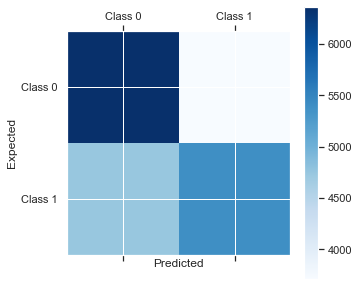

In [206]:
conf_mat_xbgoost3 = confusion_matrix(y_true = y_test3, y_pred = y_pred_xgboost3)
print('Confusion matrix:\n', conf_mat_xbgoost3)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_xbgoost3, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

#### Logistic Regression

In [207]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [208]:
## Fit the model
logit_model3 = logit.fit(reddit_train3, y_train3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.2s finished


In [209]:
y_pred_logit3 = logit_model3.predict(reddit_test3)

Accurcay 0.5480312623664424
Precision 0.5476167914337156
Recall 0.5698087162295405
F1 score 0.5584923894660545


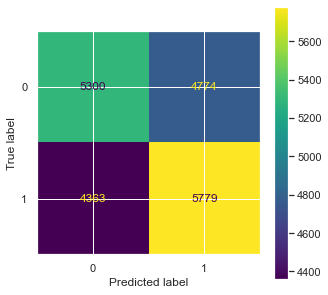

In [210]:
# print the model performance metrics
print("Accurcay",accuracy_score(y_test3, y_pred_logit3))
print("Precision", precision_score(y_test3, y_pred_logit3))
print("Recall",recall_score(y_test3, y_pred_logit3))
print("F1 score",f1_score(y_test3, y_pred_logit3))
plot_confusion_matrix(logit_model3, reddit_test3, y_test3)

#### KNN

In [211]:
knn_model3 = knn.fit(reddit_train3, y_train3) 

In [212]:
y_knn_pred3 = knn_model3.predict(reddit_test3)
y_knn_pred3

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [213]:
print(knn_model3.score(reddit_test3, y_test3)) 

0.5184507320933913


#### Random Forest

In [214]:
random_forest_model3 = random_forest.fit(reddit_train3, y_train3)

In [215]:
randomForest_predict3 = random_forest_model3.predict(reddit_test3)

In [216]:
metrics.accuracy_score(y_test3, randomForest_predict3)

0.523397309062129

Cross Validation

In [217]:
rf_cv3 = cross_val_score(random_forest_model3, reddit_train3, y_train3, n_jobs = -1)
rf_cv3

array([0.51978667, 0.51460813, 0.5241923 , 0.52021334, 0.52848419])

## PCA Analysis for dimensionality reduction

https://www.datacamp.com/community/tutorials/categorical-data

In [218]:
#category = red_copy['subreddit'].astype('category').cat.categories.tolist()
#replace_sub = {'subreddit' : {k: v for k,v in zip(category, list(range(1,len(category)+1)))}}

In [219]:
#red_copy.replace(replace_sub, inplace=True)

In [220]:
#red_copy.head()

##### TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
R = vectorizer.fit_transform(reddit_train_copy["clean"])
print(R.shape)
type(R)

##### We can use hstack to merge two sparse matrices, without having to convert to dense format.
def addFeature(R, feature_to_add):  
    return hstack([R, csr_matrix(feature_to_add).T], 'csr')

R = addFeature(R, red_copy['subreddit'])

print(R.shape)
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
sentiment_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [221]:
features1 = np.append(parent_vectorizer.get_feature_names(), subreddits_vectorizer.get_feature_names())

In [222]:
features2 = np.append(features1, sentiment_vectorizer.get_feature_names())

In [223]:
features3 = np.append(features2, ['OVERLAP_COUNT','CHAR','CAP','PUNCT','UPPERCASE'])

y_label = red_copy['label']

In [233]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=40) 
X_new = selector.fit_transform(reddit_train_copy, y_train3)
print(X_new.shape)

(64688, 40)


In [234]:
features3[selector.get_support()]

array(['irl', 'peopl', 'sarcasm', 'thank', 'white', 'women',
       'adviceanimals', 'askreddit', 'atheism', 'aww', 'canada',
       'casualconversation', 'circlejerk', 'creepypms', 'europe',
       'fireteams', 'games', 'gifs', 'globaloffensive', 'gonewild',
       'jokes', 'leagueoflegends', 'me_irl', 'mensrights', 'news',
       'pcmasterrace', 'politics', 'roastme', 'science', 'technology',
       'todayilearned', 'tumblrinaction', 'worldnews', 'negative',
       'neutral', 'OVERLAP_COUNT', 'CHAR', 'CAP', 'PUNCT', 'UPPERCASE'],
      dtype='<U22')

In [228]:
# compute chi2 scores for features and sort them from most to less relevant
from sklearn.feature_selection import chi2
stat, pval = chi2(reddit_train_copy, y_train3)
score = list(zip(features3, stat, pval))
score.sort(key = lambda tup: tup[2])
score

[('CAP', 283.1895070509356, 1.515517955103154e-63),
 ('UPPERCASE', 236.146902895195, 2.7219522370678357e-53),
 ('askreddit', 193.28491959414848, 6.10007959456187e-44),
 ('worldnews', 144.58779422523867, 2.642896929559997e-33),
 ('negative', 143.26253901749945, 5.1502506512917796e-33),
 ('creepypms', 141.94356697564803, 1.0005084033855266e-32),
 ('politics', 131.5862090175901, 1.8429461961588633e-30),
 ('OVERLAP_COUNT', 97.22265781126245, 6.195364107281793e-23),
 ('neutral', 81.58311496388882, 1.6804372507159229e-19),
 ('PUNCT', 80.8554892811318, 2.4284233463820684e-19),
 ('news', 71.31808311897422, 3.040364984992548e-17),
 ('atheism', 41.642619155387926, 1.0957829381756768e-10),
 ('CHAR', 41.005856521821, 1.5177373909792924e-10),
 ('sarcasm', 37.75071742836578, 8.038714937629785e-10),
 ('mensrights', 29.653390945442993, 5.166217689873265e-08),
 ('fireteams', 28.871174728529123, 7.735558422209483e-08),
 ('pcmasterrace', 27.54020077821115, 1.5386293596825867e-07),
 ('tumblrinaction', 25.

In [229]:
# select features with p-val less than 1%
sel = np.flatnonzero(pval < 0.01)
X_sel = reddit_train_copy[:,sel]
features_sel = features3[sel]
X_sel

<64688x101 sparse matrix of type '<class 'numpy.float64'>'
	with 351856 stored elements in Compressed Sparse Row format>

In [230]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_sel.toarray())

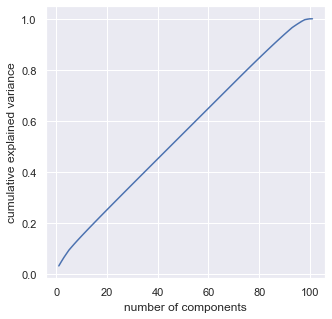

In [232]:
# PCA
from sklearn.decomposition import PCA

pca = PCA().fit(X_scale)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)
plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()